In [1]:
%matplotlib notebook
import numpy as np

from markov import *
from matplotlib import animation
from matplotlib import patches
from matplotlib import gridspec
from mpl_toolkits import mplot3d 


from threading import Event
from math import *
from random import randrange, uniform
from scipy import stats as sps 
from scipy.io import loadmat
from scipy import special as sp

In [2]:
# Funcion calculo de la matriz transicion
def log_A_f(hmm):
  tmp = np.copy(hmm.trans)
  tmp[tmp<1e-320] = 1e-320
  logA = np.log(tmp)
  return logA


In [3]:
# Funcion calculo bj(xt)
def log_bj_f(x,hmm):
  variables_amount = x.shape[1]
  states_amount = hmm.numStates-2   # Quito los estados inicial y final
  obs_amount = x.shape[0]
  pi = np.pi
  log_bj = -(variables_amount/2)*np.ones((states_amount,obs_amount))*np.log(2*pi)
  for j in range(states_amount):
    deviation = x-hmm.means[j,np.newaxis]  
    cov = hmm.vrs[j]
    inverse_cov = np.linalg.inv(cov)
    # log_bj[j,:] -= (1/2)* (np.log(np.linalg.det(cov)) + np.outer(np.outer(deviation,inverse_cov),deviation.T))
    log_bj[j,:] -= (1/2)* (np.log(np.linalg.det(cov)) + np.einsum('ij,ij->i',deviation @ inverse_cov, deviation).T)
  return log_bj

In [4]:
# Funcion recursion alpha (alpha[k,t] = bj[k,t]*sum(a[j,k]*alpha[j,t-1]) con 1<j<N-1)
def logfwd(x,hmm):
  states_amount = hmm.numStates-2   # Quito los estados inicial y final
  obs_amount = x.shape[0]             # Cantidad de observaciones, xt 
  log_alpha = np.zeros([states_amount,obs_amount])

  log_A = log_A_f(hmm)   # Matriz logaritmica de transicion
  log_bj = log_bj_f(x,hmm)  
  log_alpha[:,0] = log_bj[:,0]+log_A[0,1:-1].T    # Inicializo log_alpha (alpha[k,x1] = bj[k,x1]*pi[k])

  for t in range(1,obs_amount):
    for k in range(states_amount):
      log_alpha[k,t] = log_bj[k,t] + sp.logsumexp(log_A[1:-1,k+1] + log_alpha[:,t-1])
  
  log_prob = sp.logsumexp(log_A[1:-1,-1]+log_alpha[:,-1])     # Calculo de la probabilidad
  return log_prob, log_alpha

In [5]:
# Funcion recursion beta (beta[k,t] = sum(a[k,j]*bj[j,t+1]*beta[j,t+1]) con 1<j<N-1)
def logbwd(x,hmm):
  states_amount = hmm.numStates-2
  obs_amount = x.shape[0]
  log_A = log_A_f(hmm)
  log_bj = log_bj_f(x,hmm)
  log_beta = np.zeros([states_amount,obs_amount])

  # for k in range(states_amount):    # VER 
  log_beta[:,obs_amount-1] = log_A[1:-1,states_amount+1]  # Inicializo log_beta con akN, 1<k<N-1

  beta_linspace = np.arange(0,obs_amount-1)
  beta_linspace = reversed(beta_linspace)
  for t in beta_linspace:
  # for t in range(obs_amount-1,-1,-1):
    for k in range(states_amount):
      log_beta[k,t] = sp.logsumexp(log_A[k+1,1:-1] + log_bj[:,t+1] + log_beta[:,t+1])
    
  log_prob = sp.logsumexp(log_A[0,1:-1] + log_bj[:,0] + log_beta[:,0])
  return log_prob, log_beta

In [6]:
# Funcion gamma (gamma[j,t] = (alpha[j,t]*beta[j,t])/sum(alpha[j,t]*beta[j,t]) para todo j)
# gamma : probabilidad de haber estado en estado j cuando el modelo pasaba por tiempo t
def log_gamma_f(log_alpha,log_beta):
  num = log_alpha + log_beta
  den = sp.logsumexp(num,axis = 0)[0]
  log_gamma = num.T- den
  return log_gamma.T

In [7]:
# Funcion xi (xi[k,j,t] = (alpha[k,t-1]*a[k,j]*bj[j,t]*beta[j,t])/ sum(alpha[i,t]*beta[i,t]) para todo i )
# xi : probabilidad de saltar al estado j en tiempo t, habiendo estado en tiempo t-1 en estado i considerando las observaciones
def log_xi_f(x, hmm, log_alpha, log_beta):
  states_amount = hmm.numStates-2
  obs_amount = x.shape[0]
  log_A = log_A_f(hmm)
  log_bj = log_bj_f(x,hmm)
  log_xi = np.zeros([states_amount,states_amount,obs_amount-1])

  for t in range(obs_amount-1):
    for k in range(states_amount):
      for j in range(states_amount):
        log_xi[k,j,t] = sp.logsumexp(log_alpha[k,t] + log_A[k+1,j+1] + log_bj[j,t+1] +log_beta[j,t+1])
  den = sp.logsumexp(log_alpha + log_beta, axis=0)[0]
  log_xi -= den
  return log_xi

In [8]:
def n_k_f(x,states_amount,gamma):
  nk = np.zeros(states_amount)

  for k in range(states_amount):
    nk[k] = sum(gamma[k,:])
  return nk

In [9]:
def mean_k_f(x,states_amount,gamma):
  dimensions = x.shape[1]
  mean = np.zeros([states_amount,dimensions])
  n_k = n_k_f(x,states_amount,gamma)

  for k in range(states_amount):
    mean[k] = sum((gamma[k,:].T*x[:].T).T)/n_k[k]
  return mean

In [10]:
def cov_k_f(x,states_amount,obs_amount,mean_k,gamma):
  dimensions = x.shape[1]
  cov = np.zeros([states_amount,dimensions,dimensions])
  n_k = n_k_f(x,states_amount,gamma)

  for k in range(states_amount):
    for t in range(obs_amount):
      deviation = (x[t]-mean_k[k])
      cov[k] += (gamma[k,t]*np.outer(deviation,deviation.T))/n_k[k]   
  return cov

In [11]:
# Funcion calculo matriz transicion (aij[i,j] = sum(xi[i,j,t])/sum(gamma[j,t]))
def aij_f(states_amount,log_xi,log_gamma):
  aij = np.zeros([states_amount+2,states_amount+2])
  gamma = np.exp(log_gamma)
  n_k = n_k_f(x,states_amount,gamma)
  log_xi_sum = sp.logsumexp(log_xi,axis = 2)
  
  aij[0,1] = 1
  aij[states_amount+1,states_amount+1] = 1
  for i in range(1,states_amount+1):
    for j in range(1,states_amount+1):
      aij[i,j] = np.exp(log_xi_sum)[i-1,j-1]/n_k[i-1]
  aij[1:-1,states_amount+1] = 1 - np.sum(aij[1:-1,1:-1], axis=1)    #aiN
  # if (aij[1:-1,states_amount+1] < 0):
  #   aij[1:-1,states_amount+1] = np.abs(aij[1:-1,states_amount+1])
  return aij

In [12]:
# Calculo EM
# Paso E
def PasoE(x,hmm):
    log_alpha_prob,log_alpha = logfwd(x,hmm)
    log_beta_prob,log_beta = logbwd(x,hmm)
    log_gamma = log_gamma_f(log_alpha,log_beta)
    log_xi = log_xi_f(x, hmm, log_alpha, log_beta)
    return log_gamma,log_xi,log_alpha_prob #, log_beta_prob

In [13]:
# Paso M
def PasoM(x,log_gamma,log_xi):
  gamma = np.exp(log_gamma)
  mean_k = mean_k_f(x,states_amount,gamma)
  cov_k = cov_k_f(x,states_amount,obs_amount,mean_k,gamma)
  aij = aij_f(states_amount,log_xi,log_gamma)
  return mean_k,cov_k,aij

In [14]:
def ellipse(cov):
    At = np.linalg.cholesky(cov)   # sigma = promedio de covarianzas
    y1 = np.cos(np.arange(0, 2*np.pi, 0.01))
    y2 = np.sin(np.arange(0, 2*np.pi, 0.01))
    Y = np.matrix([y1, y2])
    At = At.dot(Y)
    At = np.transpose(At)
    return At

In [15]:
# Entrenamiento
x = loadmat('secuencia_evaluacion_BW_lutzelschwab.mat')
X = x['X']

HMM = GenData()
# print(HMM)
hmm = HMM[3]
initial_mean = hmm.means
initial_cov = hmm.vrs
initial_A = hmm.trans
initial_At = np.array([ellipse(initial_cov[0]),ellipse(initial_cov[1]),ellipse(initial_cov[2])])
obs_amount = X.shape[0]
dimensions = X.shape[1]
states_amount = hmm.numStates-2

hmm.__dict__


{'devs': array([[[ 35.,  20.],
         [ 20., 230.]],
 
        [[ 50.,   5.],
         [  5., 190.]],
 
        [[ 80.,  40.],
         [ 40., 130.]]]), 'dim': 2, 'means': array([[ 730., 1090.],
        [ 270., 2290.],
        [ 440., 1020.]]), 'numStates': 5, 'trans': array([[0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.95, 0.05, 0.  , 0.  ],
        [0.  , 0.  , 0.95, 0.05, 0.  ],
        [0.  , 0.  , 0.  , 0.95, 0.05],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]), 'vrs': array([[[ 1625.,  5300.],
         [ 5300., 53300.]],
 
        [[ 2525.,  1200.],
         [ 1200., 36125.]],
 
        [[ 8000.,  8400.],
         [ 8400., 18500.]]])}

In [16]:
def hmm_update(mean,vrs,trans,hmm,iteration):
  hmm.means = np.round(mean[iteration],2)
  hmm.vrs = np.round(vrs[iteration],2)
  hmm.trans = np.round(trans[iteration],2)
  return hmm.means,hmm.vrs,hmm.trans

In [17]:
# Entrenamiento, Baum-Wech
iter_amount = 10

log_gamma_k = np.zeros([iter_amount+1,states_amount,obs_amount])
n_k = np.zeros([iter_amount+1,states_amount,dimensions])
mean_k = np.zeros([iter_amount+1,states_amount,dimensions])
cov_k = np.zeros([iter_amount+1,states_amount,dimensions,dimensions])
transition_matrix = np.zeros([iter_amount+1,states_amount+2,states_amount+2])
log_xi_k = np.zeros([iter_amount+1,states_amount,states_amount,obs_amount-1])   # log_xi[k,j,t] con 1<t<T-1
log_likelihood = np.zeros([iter_amount+1])

# Inicializo los parametros (mean,cov,transition_matriz)

# Modelo de bakis equiprobable para la matriz de transicion
transition_matrix[0] = np.array([[0,1,0,0,0],[0,0.5,0.5,0,0],[0,0,0.5,0.5,0],[0,0,0,0.5,0.5],[0,0,0,0,1]])     # VER np.matrix

for k in range(states_amount):
  mean_k[0,k,:] = np.mean(X,axis=0).T   # Inicializo en media global de la secuencia
  cov_k[0,k,:,:] = np.cov(X,rowvar=False,bias=True)   # Inicializo en covarianza global 

# Curvas de nivel
At_initial = ellipse(cov_k[0,0])
cholesky_rows = At_initial.shape[0]
cholesky_cols = At_initial.shape[1]
At = np.empty([iter_amount,states_amount,cholesky_rows,cholesky_cols])
At[0] = np.array([At_initial,At_initial,At_initial])

hmm.means,hmm.vrs,hmm.trans = hmm_update(mean_k,cov_k,transition_matrix,hmm,iteration = 0)

log_gamma_k[0], log_xi_k[0], log_likelihood[0] = PasoE(X,hmm)

for iter in range(iter_amount):
 
  mean_k[iter+1],cov_k[iter+1], transition_matrix[iter+1] = PasoM(X,log_gamma_k[iter],log_xi_k[iter])
  hmm.means,hmm.vrs,hmm.trans = hmm_update(mean_k,cov_k,transition_matrix,hmm,iteration = iter+1)       # Actualizo parametros del entrenamiento

  log_gamma_k[iter+1], log_xi_k[iter+1], log_likelihood[iter+1] = PasoE(X,hmm)
  
  At_iter = np.array([ellipse(cov_k[iter+1][0]),ellipse(cov_k[iter+1][1]),ellipse(cov_k[iter+1][2])])   # Curvas de nivel por iteracion
  At[iter+1] = At_iter

  if (np.abs(log_likelihood[iter+1]-log_likelihood[iter])<1e-10):
    break

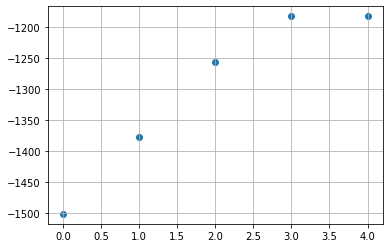

In [18]:
# Grafico likelihood por iteraciones
plt.scatter(range(iter+1),log_likelihood[0:iter+1])
plt.grid()

In [19]:
# Comparacion parametros modelos obtenidos con entrenamiento y de modelo original

print('Vector de medias de cada estado original:')
print(initial_mean)
print('Vector de medias de cada estado del entrenamiento:')
print(hmm.means)

print()

print('Vector de covarianzas de cada estado original:')
print(initial_cov)
print('Vector de covarianzas de cada estado del entrenamiento:')
print(hmm.vrs)

print()

print('Matriz de transición original:')
print(initial_A)
print('Matriz de transición del entrenamiento:')
print(hmm.trans)

Vector de medias de cada estado original:
[[ 730. 1090.]
 [ 270. 2290.]
 [ 440. 1020.]]
Vector de medias de cada estado del entrenamiento:
[[ 719.76 1100.69]
 [ 256.89 2277.22]
 [ 422.86 1007.01]]

Vector de covarianzas de cada estado original:
[[[ 1625.  5300.]
  [ 5300. 53300.]]

 [[ 2525.  1200.]
  [ 1200. 36125.]]

 [[ 8000.  8400.]
  [ 8400. 18500.]]]
Vector de covarianzas de cada estado del entrenamiento:
[[[ 1078.98  3968.46]
  [ 3968.46 46499.66]]

 [[ 1588.89   165.58]
  [  165.58 37418.36]]

 [[ 3876.15  5779.41]
  [ 5779.41 14924.09]]]

Matriz de transición original:
[[0.   1.   0.   0.   0.  ]
 [0.   0.95 0.05 0.   0.  ]
 [0.   0.   0.95 0.05 0.  ]
 [0.   0.   0.   0.95 0.05]
 [0.   0.   0.   0.   1.  ]]
Matriz de transición del entrenamiento:
[[ 0.    1.    0.    0.    0.  ]
 [ 0.    0.97  0.03  0.   -0.  ]
 [ 0.    0.    0.97  0.03 -0.  ]
 [ 0.    0.    0.    0.97  0.03]
 [ 0.    0.    0.    0.    1.  ]]


In [20]:
def ellipse_initial_plot(At,mean):
    plt.plot((1/2)*At[0,:,0] + mean[0,0], (1/2)*At[0,:,1] + mean[0,1], color = 'r')
    plt.plot((1/2)*At[1,:,0] + mean[1,0], (1/2)*At[1,:,1] + mean[1,1], color = 'g')
    plt.plot((1/2)*At[2,:,0] + mean[2,0], (1/2)*At[2,:,1] + mean[2,1], color = 'b')
    return

In [21]:
def ellipse_iter_plot(At,mean,i):
  plt.plot((1/2)*At[i+1,0,:,0] + mean[i+1,0,0] ,(1/2)*At[i+1,0,:,1] + mean[i+1,0,1],color = 'darkred')
  plt.plot((1/2)*At[i+1,1,:,0] + mean[i+1,1,0] ,(1/2)*At[i+1,1,:,1] + mean[i+1,1,1],color = 'chartreuse')
  plt.plot((1/2)*At[i+1,2,:,0] + mean[i+1,2,0] ,(1/2)*At[i+1,2,:,1] + mean[i+1,2,1],color = 'turquoise')
  return

In [22]:
def initial_mean_plot(mean):
  plt.plot(mean[0,0],mean[0,1],'x',color='r')
  plt.plot(mean[1,0],mean[1,1],'x',color='g')
  plt.plot(mean[2,0],mean[2,1],'x',color='b')
  return

In [23]:
def mean_iter_plot(mean,i):
  plt.plot(mean[i+1,0,0],mean[i+1,0,1],'x',color = 'darkred')
  plt.plot(mean[i+1,1,0],mean[i+1,1,1],'x',color = 'chartreuse')
  plt.plot(mean[i+1,2,0],mean[i+1,2,1],'x',color = 'turquoise')
  return

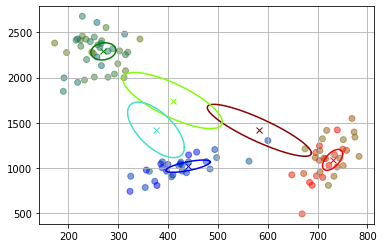

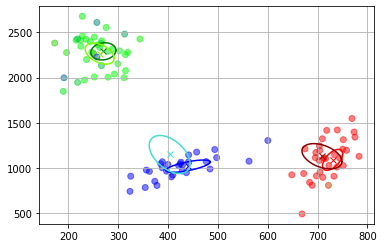

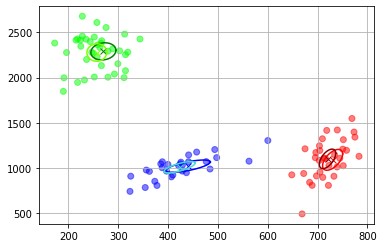

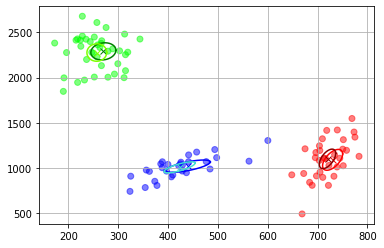

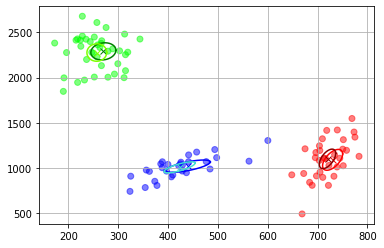

In [24]:
# Comparacion parametros modelos obtenidos con entrenamiento y de modelo original
# mediante grafico de las medias y curvas de nivel de las gaussianas

for i in range(iter+1):
  plt.scatter(X.T[0],X.T[1], color=[np.round(np.exp(log_gamma_k[i][:,j]),states_amount) for j in range(X.shape[0])], alpha = 0.5);

  # Medias originales
  initial_mean_plot(initial_mean)

  # Curvas de nivel originales
  if (iter == 0):
    ellipse_initial_plot(initial_At,initial_mean)

  else:
    ellipse_initial_plot(initial_At,initial_mean)
    # Medias obtenidas con entrenamiento
    mean_iter_plot(mean_k,i)
    # Curvas de nivel obtenidas con entrenamiento
    ellipse_iter_plot(At,mean_k,i)

  plt.grid()
  plt.show()


[]

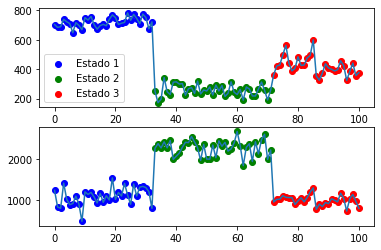

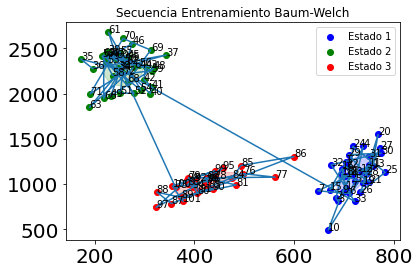

In [25]:
# Grafico secuencia entrenamiento Baum-Welch usando funciones plotseq y plotseq2 de markov.py
states_seq = np.zeros([obs_amount+2])
states_seq[-1] = states_amount+1
states_seq[1:-1] = np.argmax(log_gamma_k[iter+1],axis=0)+1

# plt.figure()
# plt.title('Secuencia Entrenamiento Baum-Welch')
ax1, ax2 = plotseq(hmm,states_seq,X)

ax3 = plotseq2(hmm,states_seq,X,gauss=True)
plt.title('Secuencia Entrenamiento Baum-Welch')
plt.plot()

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3
 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 4 4 4
 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7]
Secuencia de modelos ocurrida:
HMM[3]
HMM[3]
HMM[3]
HMM[3]
HMM[3]
HMM[3]
HMM[3]
HMM[3]
HMM[3]
HMM[3]
HMM[3]
HMM[3]
HMM[3]
HMM[3]
HMM[3]
HMM[3]
HMM[3]
HMM[3]
HMM[3]
HMM[3]
HMM[3]
HMM[3]

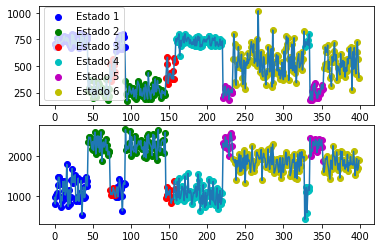

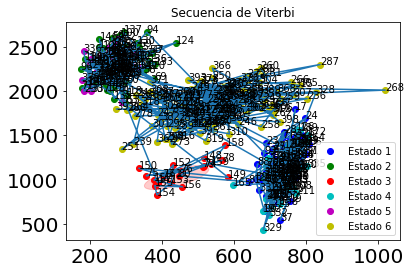

In [26]:
# Algoritmo de Viterbi

HMM2 = GenData()
x_viterbi = loadmat('secuencia_viterbi_lutzelschwab.mat')
X_viterbi = x_viterbi['X46']

# Construccion de modelo oculto de Markov siendo composición de los modelos HMM[3] y HMM[5]
hmm_viterbi = HMM2[3]
states_amount_viterbi = (HMM2[3].numStates + HMM2[5].numStates) - 2
models_amount = 2
model_states_amount = HMM2[3].numStates - 2

# Matriz de transicion compuesta con probabilidad equiprobable de empezar en un modelo u otro,
# de repetir un modelo u otro y de terminar despues de haber llegado a cualquier estado final
# y dentro de los estados interiores tendra las transiciones de los modelos originales

transition_matrix_viterbi = np.zeros([states_amount_viterbi,states_amount_viterbi])
prob_state = 0.95   # Probabilidad de seguir en el estado actual
prob_change_state = (1-0.95)   # Probabilidad de cambiar al otro estado
changes_amount = 3  
prob_change_state_model = prob_change_state/changes_amount 

# Probabilidades de cada modelo
transition_matrix_viterbi[0,1] = (1/models_amount)
transition_matrix_viterbi[0,4] = (1/models_amount)
transition_matrix_viterbi[states_amount_viterbi-1,states_amount_viterbi-1] = 1

# Probabilidad de quedar en el mismo estado para cada modelo
# Primer modelo
transition_matrix_viterbi[1,1] = prob_state
transition_matrix_viterbi[2,2] = prob_state
transition_matrix_viterbi[3,3] = prob_state
# Segundo modelo
transition_matrix_viterbi[4,4] = prob_state
transition_matrix_viterbi[5,5] = prob_state
transition_matrix_viterbi[6,6] = prob_state

# Probabilidad de cambiar de estado para cada modelo
# Primer modelo
transition_matrix_viterbi[1,2] = prob_change_state
transition_matrix_viterbi[2,3] = prob_change_state

# Segundo modelo
transition_matrix_viterbi[4,5] = prob_change_state
transition_matrix_viterbi[5,6] = prob_change_state

# Probabilidad 
transition_matrix_viterbi[3,1] = prob_change_state_model
transition_matrix_viterbi[3,4] = prob_change_state_model
transition_matrix_viterbi[3,7] = prob_change_state_model
transition_matrix_viterbi[6,1] = prob_change_state_model
transition_matrix_viterbi[6,4] = prob_change_state_model
transition_matrix_viterbi[6,7] = prob_change_state_model

# print(transition_matrix_viterbi)

hmm_viterbi.devs = np.append(hmm_viterbi.devs,HMM2[5].devs,axis=0)
hmm_viterbi.means = np.append(hmm_viterbi.means,HMM2[5].means,axis=0)
hmm_viterbi.numStates = 8
hmm_viterbi.trans = transition_matrix_viterbi
hmm_viterbi.vrs = np.append(hmm_viterbi.vrs,HMM2[5].vrs,axis=0)

# Calculo logaritmo viterbi funcion de archivo markov.py
cost_viterbi, seq_viterbi = logvit(X_viterbi,hmm_viterbi)

ax1, ax2 = plotseq(hmm_viterbi,seq_viterbi,X_viterbi)
ax3 = plotseq2(hmm_viterbi,seq_viterbi,X_viterbi,gauss=True)
plt.title('Secuencia de Viterbi')
plt.plot()

print(seq_viterbi)
seq_viterbi_len = len(seq_viterbi)
hmm3_amount = 0
hmm5_amount = 0

print('Secuencia de modelos ocurrida:')
for i in range(seq_viterbi_len):
  if(seq_viterbi[i] == 1 or seq_viterbi[i] == 2 or seq_viterbi[i] == 3):
    hmm3_amount += 1
    print('HMM[3]')
  if(seq_viterbi[i] == 4 or seq_viterbi[i] == 5 or seq_viterbi[i] == 6):
    hmm5_amount += 1
    print('HMM[5]')
print('Cantidad de la secuencia modelo 3:',hmm3_amount)
print('Cantidad de la secuencia modelo 5:',hmm5_amount)
